# Product/Face Detection/Recognition Service

This notebook, contain a novel approach for refinement of the data for YOLO, and trained YOLO model for face detection/recognition, that will be compitable with Product and logo detection and recognition.

### Install Dependencies and Setup

In [1]:
!pip install ultralytics

## Clone the repo

In [ ]:
!git clone https://github.com/LeonZlotnik/FaceRecognition2.git

## Importing required Packages

In [3]:
import os
import json
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Configuration

In [4]:
cd FaceRecognition2/

/content/FaceRecognition2


In [5]:
data_folder = './data/'
label_dir_train = './data/train/labels'
label_dir_val = './data/val/labels'
img_dir_train = './data/train/images'
img_dir_val = './data/val/images'
output_dir_train = label_dir_train  # Labels will be saved in the same folder
output_dir_val = label_dir_val

## Accessories

In [6]:
# to convert JSON labels to YOLO format
def convert_to_yolo_format(json_data, img_width, img_height):
    yolo_labels = []
    for shape in json_data['shapes']:
        if shape['label'] == 'face':
            points = shape['points']

            x1, y1 = points[0]
            x2, y2 = points[1]


            x_center = (x1 + x2) / 2 / img_width
            y_center = (y1 + y2) / 2 / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height

            # Append class_id (face = 0) and normalized coordinates
            yolo_labels.append(f"0 {x_center} {y_center} {width} {height}")
    return yolo_labels

# Convert all JSON files to YOLO format
for filename in os.listdir(data_folder):
    if filename.endswith('.json'):
        json_path = os.path.join(data_folder, filename)
        with open(json_path, 'r') as f:
            data = json.load(f)

        img_width = data['imageWidth']
        img_height = data['imageHeight']
        yolo_labels = convert_to_yolo_format(data, img_width, img_height)

        # Save YOLO labels to a .txt file with the same name as the image
        txt_filename = filename.replace('.json', '.txt')
        txt_path = os.path.join(data_folder, txt_filename)
        with open(txt_path, 'w') as f:
            f.write('\n'.join(yolo_labels))


In [7]:
def convert_to_yolo_format(json_file, img_width, img_height):
    """Converts JSON bounding boxes to YOLO format."""
    yolo_data = []
    with open(json_file, 'r') as f:
        data = json.load(f)
        shapes = data['shapes']

        for shape in shapes:
            label = 0  # Assuming 'face' is the only class, thus class_id is 0
            points = shape['points']
            x_min, y_min = points[0]
            x_max, y_max = points[1]

            # Compute YOLO format
            x_center = (x_min + x_max) / 2.0 / img_width
            y_center = (y_min + y_max) / 2.0 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            yolo_data.append(f"{label} {x_center} {y_center} {width} {height}")

    return yolo_data

def convert_json_to_txt(label_dir, output_dir, img_dir):
    """Converts all JSON label files in a directory to YOLO .txt format."""
    for json_filename in os.listdir(label_dir):
        if json_filename.endswith('.json'):
            json_path = os.path.join(label_dir, json_filename)
            with open(json_path, 'r') as f:
                data = json.load(f)
                image_path = os.path.join(img_dir, os.path.basename(data['imagePath']))
                img_width = data['imageWidth']
                img_height = data['imageHeight']

                yolo_data = convert_to_yolo_format(json_path, img_width, img_height)

                # Write YOLO label file
                output_txt_path = os.path.join(output_dir, json_filename.replace('.json', '.txt'))
                with open(output_txt_path, 'w') as txt_file:
                    txt_file.write("\n".join(yolo_data))

# Convert train and val sets
convert_json_to_txt(label_dir_train, output_dir_train, img_dir_train)
convert_json_to_txt(label_dir_val, output_dir_val, img_dir_val)


## Model Training

In [ ]:
# Load a YOLOv8n model, available variants are yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
model = YOLO('yolov8n.pt')  # Download and load the pre-trained YOLOv8n model

# Train the model
model.train( data='./data/config.yaml', epochs=100, imgsz=640, batch=8)


## Model Evaluation

In [ ]:
# Validate the model
metrics = model.val()
print(metrics)


Ultralytics 8.3.20 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/FaceRecognition2/data/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


                   all         15         15      0.999          1      0.995       0.75
Speed: 0.5ms preprocess, 27.4ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train32
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed7a3052dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.0

## Test on all images


image 1/1 /content/FaceRecognition2/data/test/images/e46f55c4-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


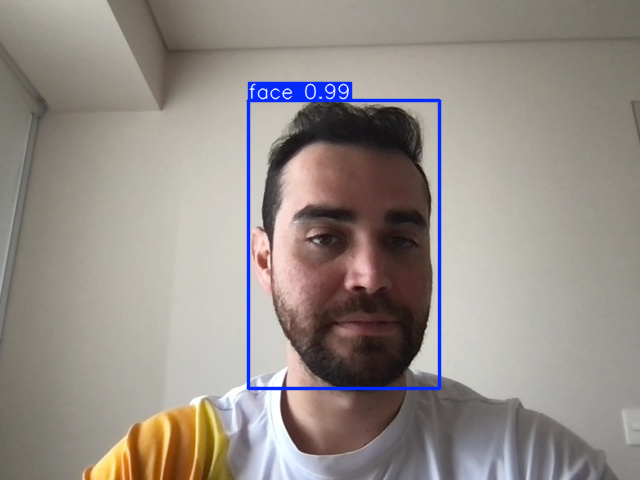


image 1/1 /content/FaceRecognition2/data/test/images/dd1b0962-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


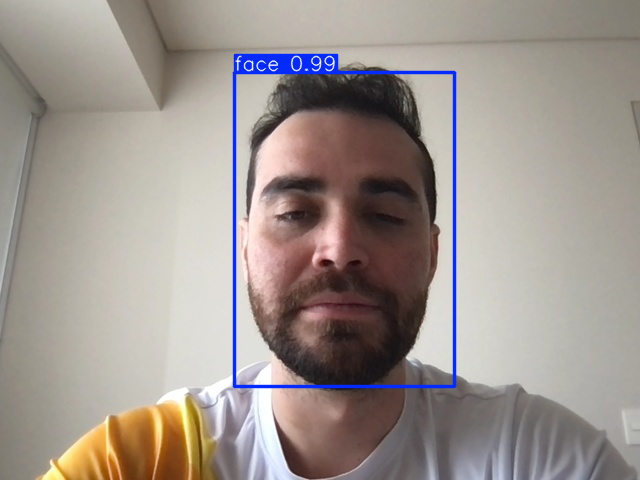


image 1/1 /content/FaceRecognition2/data/test/images/e0c6e784-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


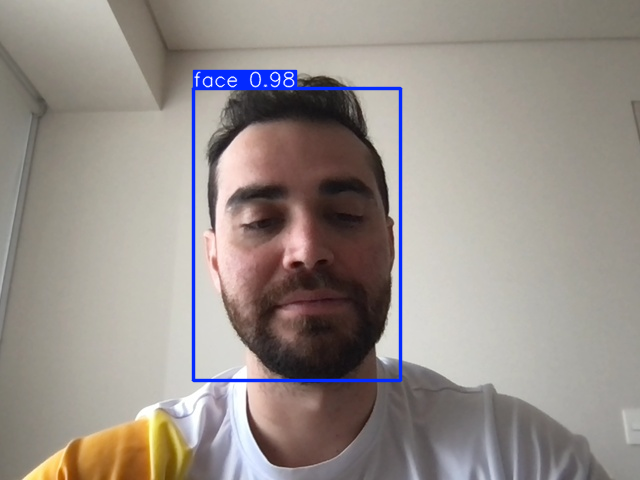


image 1/1 /content/FaceRecognition2/data/test/images/e82053ee-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


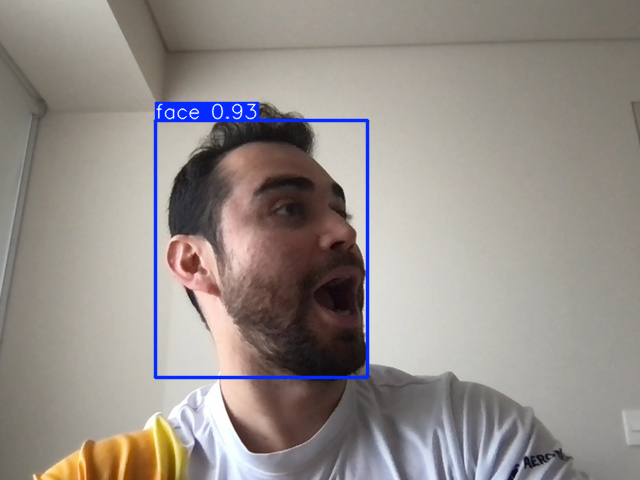


image 1/1 /content/FaceRecognition2/data/test/images/e385cfbc-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 2 faces, 12.1ms
Speed: 1.8ms preprocess, 12.1ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


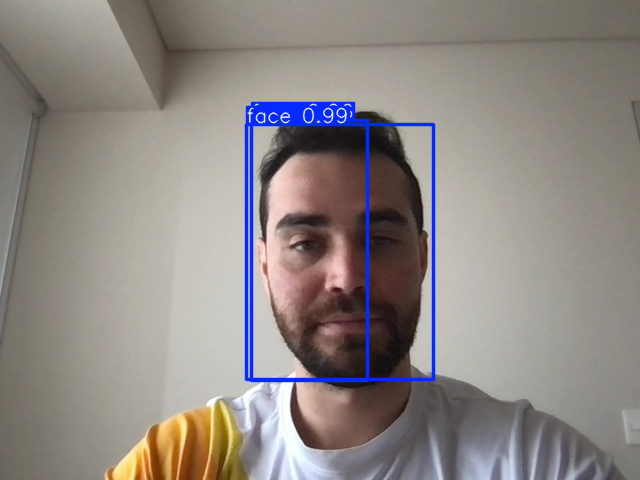


image 1/1 /content/FaceRecognition2/data/test/images/e90bb302-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 16.6ms
Speed: 2.6ms preprocess, 16.6ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)


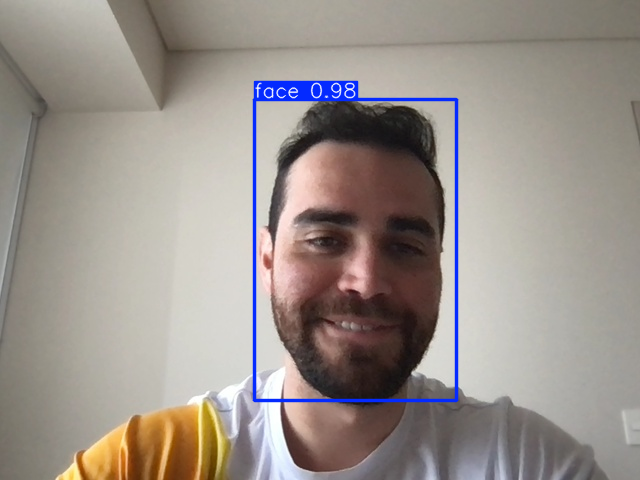


image 1/1 /content/FaceRecognition2/data/test/images/dc30cbd6-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 17.5ms
Speed: 1.9ms preprocess, 17.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


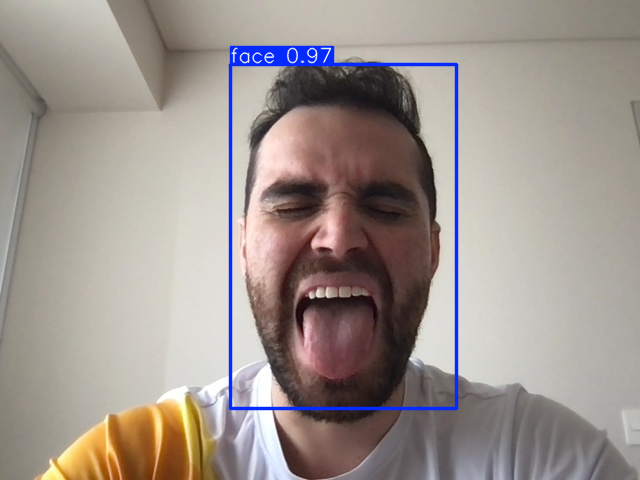


image 1/1 /content/FaceRecognition2/data/test/images/e29ae45c-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 2 faces, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


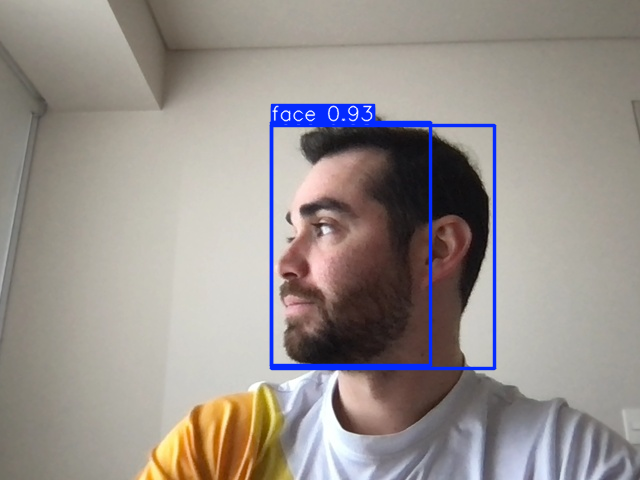


image 1/1 /content/FaceRecognition2/data/test/images/e648f29c-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 2 faces, 11.3ms
Speed: 1.9ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


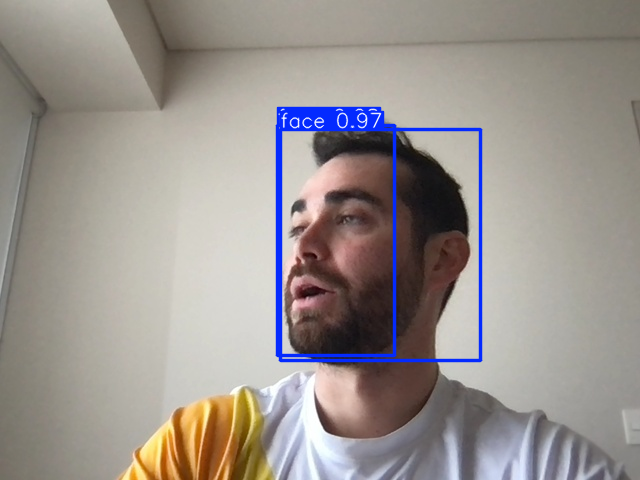


image 1/1 /content/FaceRecognition2/data/test/images/e7366e0a-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 2 faces, 12.5ms
Speed: 1.9ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


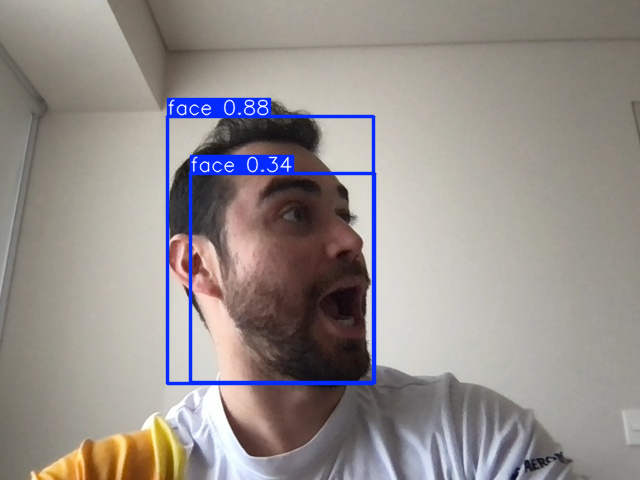


image 1/1 /content/FaceRecognition2/data/test/images/de05db40-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 2 faces, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


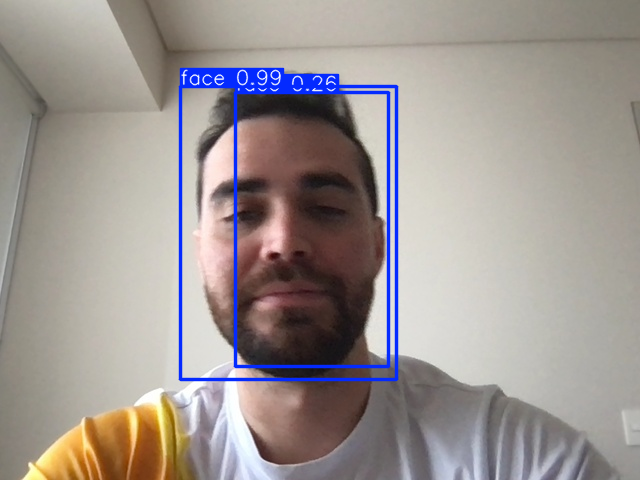


image 1/1 /content/FaceRecognition2/data/test/images/def37e86-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


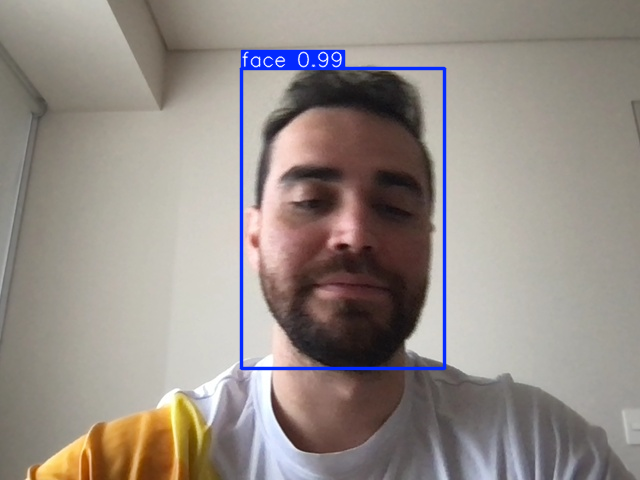


image 1/1 /content/FaceRecognition2/data/test/images/dfde9f60-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


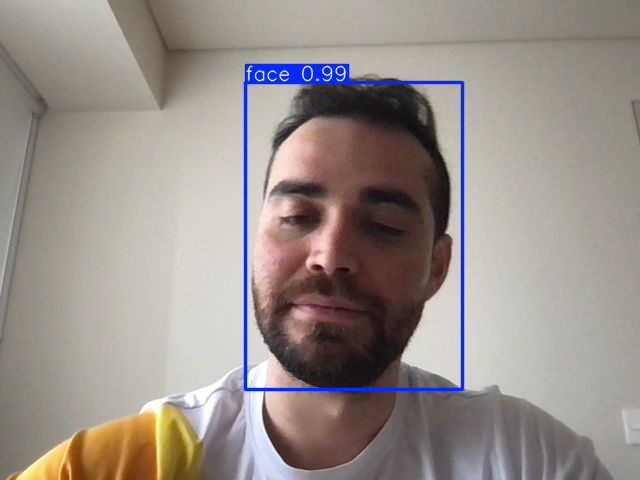


image 1/1 /content/FaceRecognition2/data/test/images/e55d99be-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


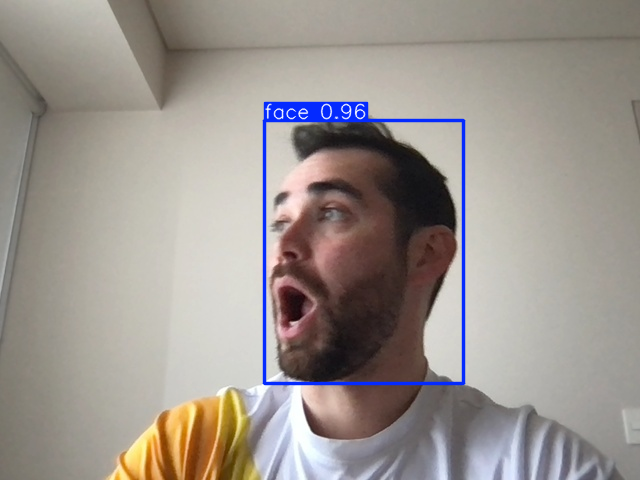


image 1/1 /content/FaceRecognition2/data/test/images/e1b0b72e-8d90-11ef-b7d1-a683e7996e5e.jpg: 480x640 1 face, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


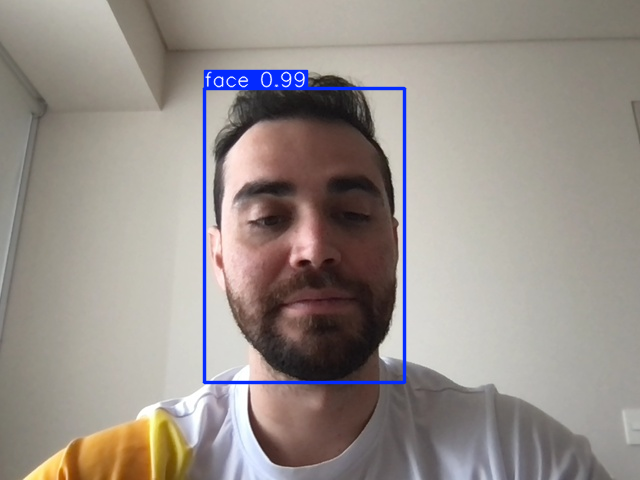

In [ ]:
test_images_folder = './data/test/images'

# Get a list of all image file paths in the directory
image_paths = [os.path.join(test_images_folder, file) for file in os.listdir(test_images_folder) if file.endswith(('jpg', 'jpeg', 'png'))]

# Loop through each image in the directory
for image_path in image_paths:
    # Apply the model on each image
    results = model(image_path)

    # Access the first result (assuming the model returns a list of results)
    # and display it using a library like PIL or Matplotlib
    if results:
        results[0].show()  # Assuming `show()` is a method in your results object
    else:
        print(f"No result for image {image_path}")

## Live Testing

In [ ]:
import cv2
import json
import torch

model = torch.load('./runs/detect/train/weights/best.pt')

# Initialize webcam
cap = cv2.VideoCapture(0)

# Real-time detection loop
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Perform detection on the frame
    results = model(frame)

    # Extract predictions and format for display and output
    predictions = []
    group_id_counter = 1

    for pred in results[0].boxes:
        bbox = pred.xyxy[0].cpu().numpy().tolist()

        group_id = getattr(pred, 'group_id', None)
        if group_id is None:
            group_id = group_id_counter
            group_id_counter += 1

        # Append to predictions
        predictions.append({
            "label": "face",
            "points": [
                [bbox[0], bbox[1]],
                [bbox[2], bbox[3]]
            ],
            "group_id": group_id,
            "description": "",
            "shape_type": "rectangle",
            "flags": {}
        })

        # Draw bounding boxes on the frame
        cv2.rectangle(
            frame,
            (int(bbox[0]), int(bbox[1])),
            (int(bbox[2]), int(bbox[3])),
            (255, 0, 0), 2
        )
        cv2.putText(frame, "face", (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Print real-time JSON predictions
    json_output = json.dumps(predictions, indent=4)
    print(json_output)

    # Display the live video feed with detections
    cv2.imshow('Real-Time Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

## Conclusion

With the comparison to all models, VGG, facenet, Multi-Task CNN, etc, YOLO model is performing well.